In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import tskit
import tsinfer

print(f"tskit {tskit.__version__}")
print(f"tsinfer {tsinfer.__version__}")

/home/shing_zhan/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


tskit 0.5.2
tsinfer 0.2.3


### Load data

In [2]:
base_dir = Path("/home/shing_zhan/analysis/tuning/")
ts_file = base_dir / "a-7s-7.1Mb.inferred.trees"

In [3]:
ts = tskit.load(ts_file)
ts

### Examine the correlation between edge span and edge time

In [4]:
edge_spans = ts.edges_right - ts.edges_left
edge_parent_times = ts.nodes_time[ts.edges_parent]
edge_child_times = ts.nodes_time[ts.edges_child]

if edge_spans[-1] == ts.sequence_length:
    edge_spans = edge_spans[:-2]
    edge_parent_times = edge_parent_times[:-2]
    edge_child_times = edge_child_times[:-2]

edge_spans = edge_spans / 1e6

df_edges = pd.DataFrame({
    'edge_spans': edge_spans,
    'edge_parent_times': edge_parent_times,
    'edge_child_times': edge_child_times,
})

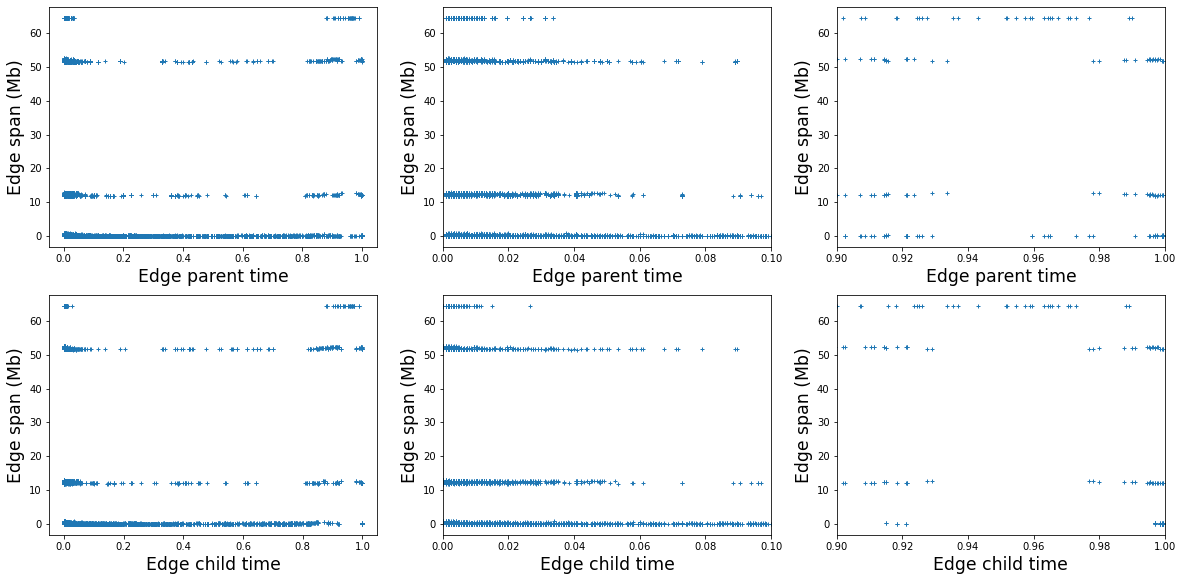

In [5]:
plt.figure(figsize=(20, 15,))

plt.subplot(331)
plt.xlabel("Edge parent time", fontsize="xx-large")
plt.ylabel("Edge span (Mb)", fontsize="xx-large")
plt.plot(
    df_edges["edge_parent_times"],
    df_edges["edge_spans"],
    linestyle='none', marker='+', markersize=4,
);

plt.subplot(332)
plt.xlabel("Edge parent time", fontsize="xx-large")
plt.ylabel("Edge span (Mb)", fontsize="xx-large")
plt.xlim(0.0, 0.1)
plt.plot(
    df_edges["edge_parent_times"],
    df_edges["edge_spans"],
    linestyle='none', marker='+', markersize=4,
);

plt.subplot(333)
plt.xlabel("Edge parent time", fontsize="xx-large")
plt.ylabel("Edge span (Mb)", fontsize="xx-large")
plt.xlim(0.9, 1.0)
plt.plot(
    df_edges["edge_parent_times"],
    df_edges["edge_spans"],
    linestyle='none', marker='+', markersize=4,
);

plt.subplot(334)
plt.xlabel("Edge child time", fontsize="xx-large")
plt.ylabel("Edge span (Mb)", fontsize="xx-large")
plt.plot(
    df_edges["edge_child_times"],
    df_edges["edge_spans"],
    linestyle='none', marker='+', markersize=4,
);

plt.subplot(335)
plt.xlabel("Edge child time", fontsize="xx-large")
plt.ylabel("Edge span (Mb)", fontsize="xx-large")
plt.xlim(0.0, 0.1)
plt.plot(
    df_edges["edge_child_times"],
    df_edges["edge_spans"],
    linestyle='none', marker='+', markersize=4,
);

plt.subplot(336)
plt.xlabel("Edge child time", fontsize="xx-large")
plt.ylabel("Edge span (Mb)", fontsize="xx-large")
plt.xlim(0.9, 1.0)
plt.plot(
    df_edges["edge_child_times"],
    df_edges["edge_spans"],
    linestyle='none', marker='+', markersize=4,
);

plt.show()


### Examine the correlation between node span and node time

In [6]:
node_spans = tsinfer.node_span(ts)
node_times = ts.nodes_time

if node_spans[-1] == ts.sequence_length:
    node_spans = node_spans[:-2]
    node_times = node_times[:-2]

node_spans = node_spans / 1e6

df_nodes = pd.DataFrame({
    'node_spans': node_spans,
    'node_times': node_times,
})

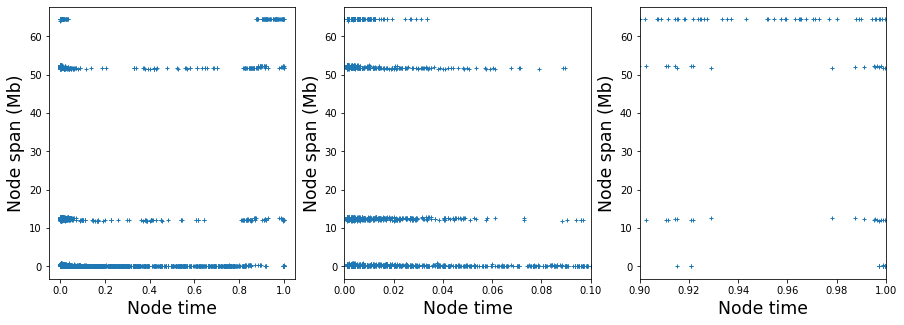

In [7]:
plt.figure(figsize=(15, 5,))

plt.subplot(131)
plt.xlabel("Node time", fontsize="xx-large")
plt.ylabel("Node span (Mb)", fontsize="xx-large")
plt.plot(
    df_nodes["node_times"],
    df_nodes["node_spans"],
    linestyle='none', marker='+', markersize=4,
);

plt.subplot(132)
plt.xlabel("Node time", fontsize="xx-large")
plt.ylabel("Node span (Mb)", fontsize="xx-large")
plt.xlim(0.0, 0.1)
plt.plot(
    df_nodes["node_times"],
    df_nodes["node_spans"],
    linestyle='none', marker='+', markersize=4,
);

plt.subplot(133)
plt.xlabel("Node time", fontsize="xx-large")
plt.ylabel("Node span (Mb)", fontsize="xx-large")
plt.xlim(0.9, 1.0)
plt.plot(
    df_nodes["node_times"],
    df_nodes["node_spans"],
    linestyle='none', marker='+', markersize=4,
);


### Distribution of mutations per site

In [8]:
site_pos, counts = np.unique(ts.mutations_site, return_counts=True)
num_sites_with_mutation = len(site_pos)
print(f"Sites total: {ts.num_sites}")
print(f"Sites with at least one mutation: {num_sites_with_mutation}")

Sites total: 6671
Sites with at least one mutation: 5692


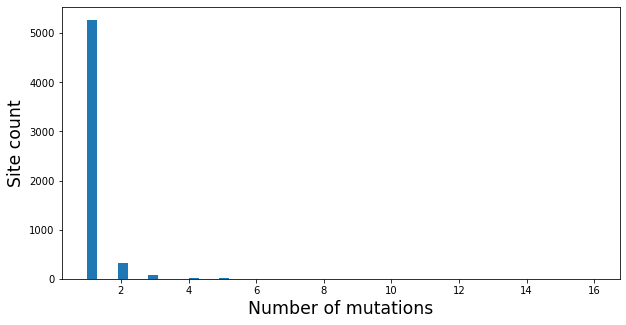

In [9]:
plt.figure(figsize=(10, 5,))
plt.ylabel("Site count", fontsize="xx-large")
plt.xlabel("Number of mutations", fontsize="xx-large")
plt.hist(counts, bins=50);
plt.show()

### Distribution of arity

In [10]:
mean_arity = np.empty(ts.num_trees)
for i, tree in enumerate(ts.trees()):
    parent_id, count = np.unique(tree.parent_array[tree.preorder()], return_counts=True)
    mean_arity[i] = count[parent_id != tskit.NULL].mean()

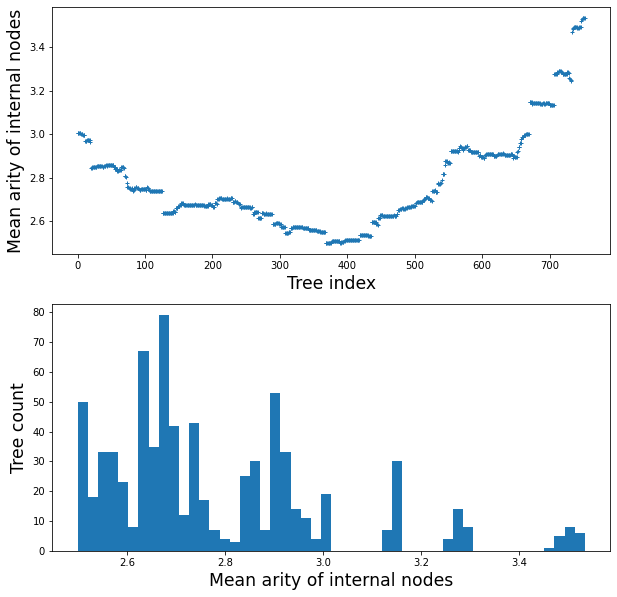

In [11]:
plt.figure(figsize=(10, 10,))

plt.subplot(211)
plt.ylabel("Mean arity of internal nodes", fontsize="xx-large")
plt.xlabel("Tree index", fontsize="xx-large")
plt.plot(
    np.arange(ts.num_trees),
    mean_arity,
    linestyle="none", marker="+", markersize=4,
);

plt.subplot(212)
plt.ylabel("Tree count", fontsize="xx-large")
plt.xlabel("Mean arity of internal nodes", fontsize="xx-large")
plt.hist(mean_arity, bins=50);

plt.show()

### Distribution of edge diffs

In [12]:
tree_edges_out = np.empty(ts.num_trees)
tree_edges_in = np.empty(ts.num_trees)
for i, (interval, edges_out, edges_in,) in enumerate(ts.edge_diffs()):
    tree_edges_out[i] = len(edges_out)
    tree_edges_in[i] = len(edges_in)

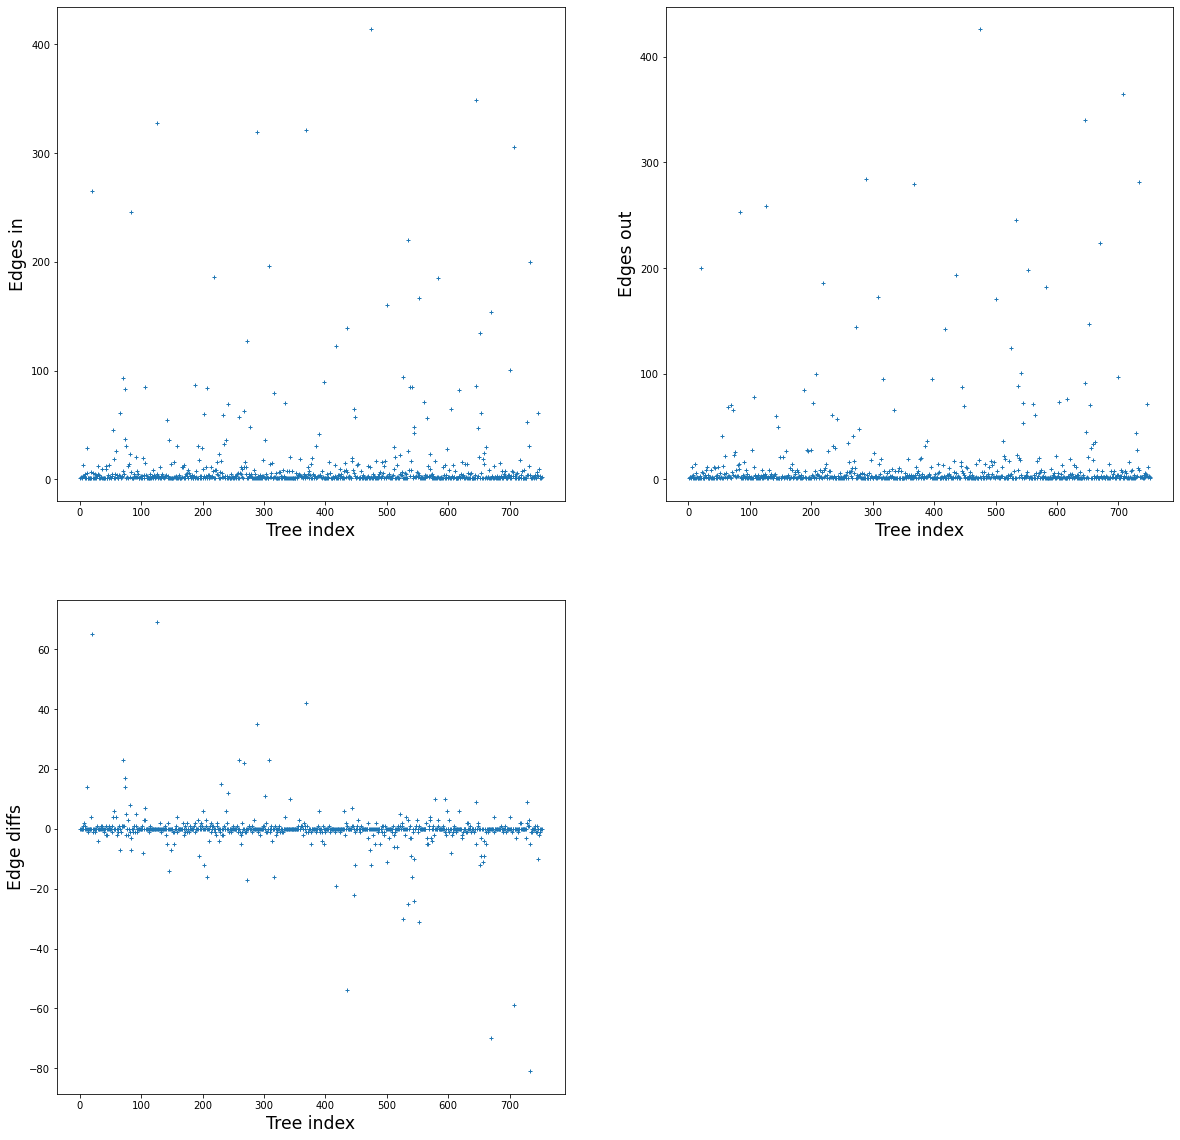

In [13]:
plt.figure(figsize=(20, 20,))

plt.subplot(221)
plt.ylabel("Edges in", fontsize="xx-large")
plt.xlabel("Tree index", fontsize="xx-large")
plt.plot(
    np.arange(1, ts.num_trees),
    tree_edges_in[1:],
    linestyle="none", marker="+", markersize=4,
);

plt.subplot(222)
plt.ylabel("Edges out", fontsize="xx-large")
plt.xlabel("Tree index", fontsize="xx-large")
plt.plot(
    np.arange(1, ts.num_trees),
    tree_edges_out[1:],
    linestyle="none", marker="+", markersize=4,
);

plt.subplot(223)
plt.ylabel("Edge diffs", fontsize="xx-large")
plt.xlabel("Tree index", fontsize="xx-large")
plt.plot(
    np.arange(1, ts.num_trees),
    tree_edges_in[1:] - tree_edges_out[1:],
    linestyle="none", marker="+", markersize=4,
);

plt.show()